In [1]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp

import jax_cosmo as jc
import os 
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import matplotlib.pyplot as plt

In [2]:
def radial_profile(data):
  """
  Compute the radial profile of 2d image
  :param data: 2d image
  :return: radial profile
  """
  center = data.shape[0]/2
  y, x = jnp.indices((data.shape))
  r = jnp.sqrt((x - center)**2 + (y - center)**2)
  r = r.astype('int32')

  tbin = jnp.bincount(r.ravel(), data.ravel())
  nr = jnp.bincount(r.ravel())
  radialprofile = tbin / nr
  return radialprofile

def measure_power_spectrum(map_data, pixel_size):
  """
  measures power 2d data
  :param power: map (nxn)
  :param pixel_size: pixel_size (rad/pixel)
  :return: ell
  :return: power spectrum
  
  """
  data_ft = jnp.fft.fftshift(jnp.fft.fft2(map_data)) / map_data.shape[0]
  nyquist = int(map_data.shape[0]/2)
  power_spectrum_1d =  radial_profile(jnp.real(data_ft*jnp.conj(data_ft)))[:nyquist] * (pixel_size)**2
  k = jnp.arange(power_spectrum_1d.shape[0])
  ell = 2. * jnp.pi * k / pixel_size / 360
  return ell, power_spectrum_1d

In [7]:
ps_list = jnp.array([jnp.load('../ps/ps_%03d.npy'%i)[1] for i in range(100)])

In [4]:
resolution = 1 # arcmin/pixel
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
# Cosmology 
cosmology = jc.Planck15(Omega_c=0.2589, sigma8=0.8159)

nzs = [jc.redshift.delta_nz(2.)]
probes = [jc.probes.WeakLensing(nzs, sigma_e=0.)]
elle = jnp.logspace(1, 5)
cls = jc.angular_cl.angular_cl(cosmology, elle, probes)

In [8]:
jnp.array(ps_list).shape

(100, 150)

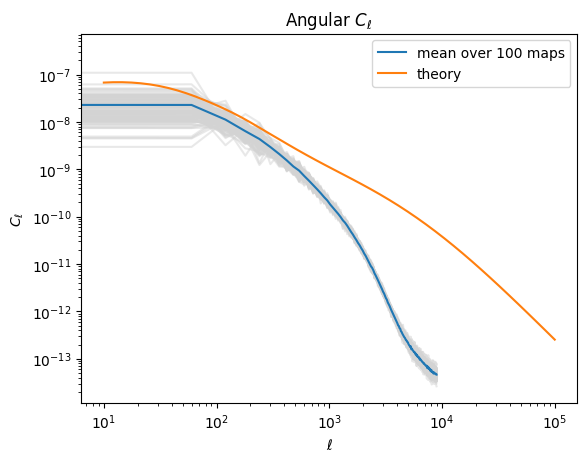

In [9]:
k = jnp.arange(ps_list[0].shape[0])
ell_map = 2. * jnp.pi * k / pixel_size / 360

for i in range(100): 
    plt.loglog(ell_map, ps_list[i], alpha=0.5, c='lightgrey')

plt.loglog(ell_map, jnp.mean(jnp.array(ps_list), axis=0), label='mean over 100 maps')
plt.loglog(elle, cls[0], label='theory')

plt.ylabel(r'$C_\ell$')
plt.xlabel(r'$\ell$');
plt.title(r'Angular $C_\ell$');
plt.legend()
plt.show()